In [1]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


Using TensorFlow backend.


In [9]:
#defining data paths and neccessary variables
DATA_PATH = "data.json"
SAVED_MODEL_PATH = "model3.h5"
EPOCHS = 40
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [10]:
def load_data(data_path):
    """Loads training dataset from json file.

    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets

    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y

In [11]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.

    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation

    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """
    
     # load dataset
    X, y = load_data(data_path)
    #y = to_categorical(y, num_classes=129, dtype='int32')

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

    

In [12]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.

    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):

    :return model: TensorFlow model
    """

    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(129, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model


In [13]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model

    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set

    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history


In [14]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()



Training sets loaded!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 11, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 11, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 4, 32)          18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 4, 32)          128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 2, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (No

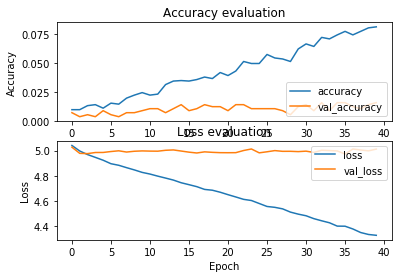

720/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [15]:
def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    # train network
    history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    # save model
    model.save(SAVED_MODEL_PATH)


if __name__ == "__main__":
    main()


## NOTE

YOU USE EITHER 'SPARSE_CATEGORICAL_CROSSENTROPY' OR 'CATEGORICAL_CROSSENTROPY' AS LOG_LOSS DEPENDING ON THE CASE.IF YOUR TARGET y is still in format [0,1,2,3....] with many classes you may need to one hot encode it as seen below or it you use 'sparse_categorical_crossentropy' else it would return an error if you try using 'categorical_crossentropy'. categorical_crossentropy works for one-hot encoded y-target variables.


ValueError: You are passing a target array of shape (2303, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.



In [17]:
model= tf.keras.models.load_model('model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
data_path = 'test_data.json'

In [21]:
def load_data(data_path):
    """Loads training dataset from json file.

    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    

    """
    with open(data_path, "r") as fp:
        test_data = json.load(fp)

    X = np.array(test_data["MFCCs"])
    
    print("Test sets loaded!")
    return X

In [22]:
import numpy as np
# load dataset
X= load_data(data_path)

Test sets loaded!


In [23]:
 X = X[..., np.newaxis]

In [25]:
ssd = model.predict(X)

In [27]:
ssd.shape

(2124, 129)

In [30]:
import pandas as pd

In [32]:
ssd = pd.DataFrame(ssd)

In [33]:
ssd.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.004836,0.008759,0.006081,0.006607,0.007960,0.002029,0.009774,0.015703,0.010750,0.004473,...,0.001778,0.005328,0.002991,0.008387,0.002243,0.003679,0.007783,0.006432,0.005668,0.022874
1,0.001679,0.000977,0.001291,0.000134,0.113457,0.002682,0.000512,0.000221,0.001916,0.000191,...,0.201649,0.000189,0.000622,0.002844,0.009649,0.002347,0.000351,0.000057,0.004329,0.001581
2,0.003907,0.003172,0.001829,0.000385,0.085967,0.002648,0.001648,0.000635,0.002791,0.000751,...,0.124747,0.000385,0.000839,0.003254,0.015649,0.005176,0.001566,0.000367,0.008385,0.005206
3,0.004597,0.006620,0.004553,0.002949,0.010411,0.004124,0.007057,0.006051,0.005141,0.015946,...,0.006388,0.003412,0.011041,0.011056,0.002023,0.013517,0.006663,0.008582,0.005793,0.002679
4,0.009424,0.007139,0.006553,0.011180,0.012438,0.004491,0.006616,0.008999,0.008850,0.009879,...,0.005724,0.008388,0.009679,0.005680,0.004439,0.010458,0.011988,0.005852,0.008830,0.010547


In [34]:
ssd.to_csv('motus.csv')